https://github.com/slundberg/shap

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
tf.set_random_seed(2)
config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

/data/xai/src/stylesage-experiments/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/xai/src/stylesage-experiments/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/xai/src/stylesage-experiments/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/xai/src/stylesage-expe

In [2]:
import os
import keras
from keras.preprocessing import image
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.3.1


In [3]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import shap
import keras.backend as K
import json
shap.initjs()


def visualize_model_decisions(shap_values, x, labels=None, figsize=(20, 30)):
    
    colors = []
    for l in np.linspace(1, 0, 100):
        colors.append((30./255, 136./255, 229./255,l))
    for l in np.linspace(0, 1, 100):
        colors.append((255./255, 13./255, 87./255,l))
    red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    # plot our explanations
    fig_size = figsize
    fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.
        
        axes[row,0].imshow(x_curr)
        axes[row,0].axis('off')
        
        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(labels[row,i])
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[0], sv.shape[1], -1))
            im = axes[row,i+1].imshow(sv, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
        
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/0.2)
    cb.outline.set_visible(False)

# Load a pre-trained CNN - Inception


In [4]:
from keras_preprocessing.image import img_to_array
from keras.models import load_model

model = load_model('finetune.model')
model.load_weights('weights.best.hdf5')

print(model.summary())




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_________________________________________________________________________________________

In [5]:
def preprocess_input_inceptionv3(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def load_image(path): 
  img = Image.open(path)
  img = np.array(img)
  x = img_to_array(img)
  x = preprocess_input_inceptionv3(x)

  return x

# Load Sample Dataset

In [6]:
from PIL import Image, ImageDraw
from os import listdir
from os.path import isfile, join

mypath = 'images/1888'
X = [load_image(join(mypath, f)) for f in listdir(mypath) if isfile(join(mypath, f))][:50]
x = 'images/1888/c29977b941a2168c312319e55907028a3dc1fb45.jpg'
len(X)

50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


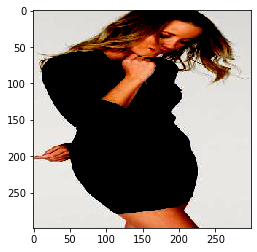

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

to_predict = np.array([load_image(x)])
plt.imshow(to_predict[0])

# Get Model Predictions on Sample Images

In [9]:
class_names = {
    0: '1886 - Accessories', 
    1: '1887 - Swimwear', 
    2: '1888 - One piece',
    3: '1889 - Upper part', 
    4: '1890 - Shoes', 
    5: '1891 - Bottom part', 
    6: '1892 - Underwear'
}

In [10]:
predictions = model.predict(to_predict.copy())
predictions, predictions.shape

(array([[6.5212462e-06, 3.8848946e-05, 9.9692142e-01, 2.8786673e-03,
         7.2517878e-07, 1.2986138e-05, 1.4079170e-04]], dtype=float32),
 (1, 7))

In [11]:
predicted_labels = [class_names.get(pred) for pred in np.argmax(predictions, axis=1)]
print(predicted_labels)

['1888 - One piece']


In [12]:
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

# Use SHAP GradientExplainer to explain model prediction decisions

Combines ideas from Integrated Gradients, SHAP, and SmoothGrad into a single expected value equation. This allows an entire dataset to be used as the background distribution (as opposed to a single reference value) and allows local smoothing. If we approximate the model with a linear function between each background data sample and the current input to be explained, and we assume the input features are independent then expected gradients will compute approximate SHAP values.

We usually get gradients of the class score function with respect to the input image. These gradients can be interpreted as a sensitivity map. Red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class.

In [13]:
from vis.utils import utils

layer_idx = 18  # utils.find_layer_idx(model, 'conv2d_94')
print(layer_idx)

18


## Explain  how the 18th intermediate layer impacts predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


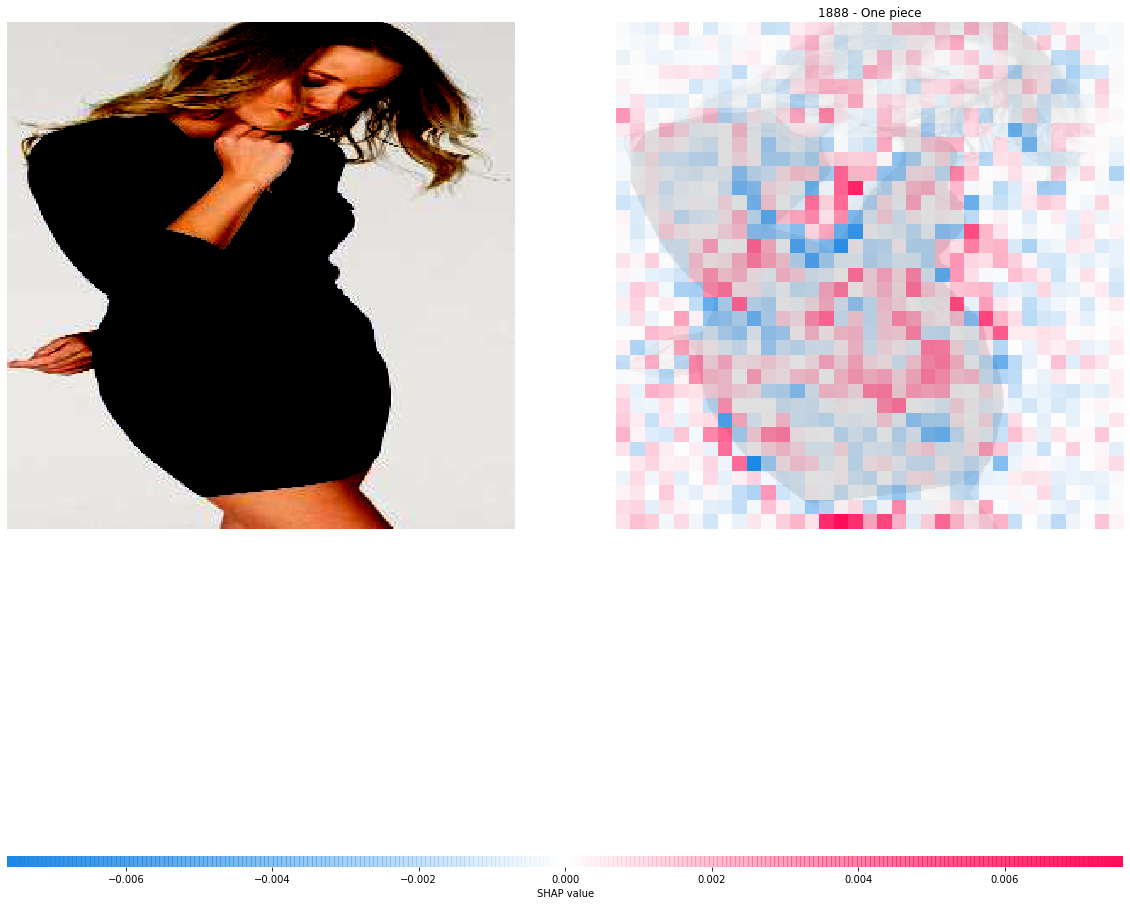

In [14]:
e = shap.GradientExplainer((model.layers[layer_idx].input, model.layers[-1].output), 
                            map2layer(X.copy(), layer_idx))
shap_values, indexes = e.shap_values(map2layer(to_predict, layer_idx), ranked_outputs=1)
index_names = np.vectorize(lambda x: class_names[x])(indexes)
visualize_model_decisions(shap_values=shap_values, x=to_predict, labels=index_names, figsize=(20, 40))